
#### Comparing Matrix Profile Model (new approach) to existing anomaly models

References
* https://www.cs.umn.edu/research/technical_reports/view/09-004
* https://www.cs.ucr.edu/~eamonn/Matrix_Profile_Tutorial_Part1.pdf
* https://towardsdatascience.com/the-matrix-profile-e4a679269692


#### Conclusions and Discussions ####

For the user:
1. how many discords do they want to mark for a given cronjob frequecy?
2. z-norm and non-norm version - when to use one vs. other: use znorm if the range is too high for data?

Martix Profile is a pairwise Euclidean distance of a subsequence to it's nearest neighbor

*show images for all the datasets ran*
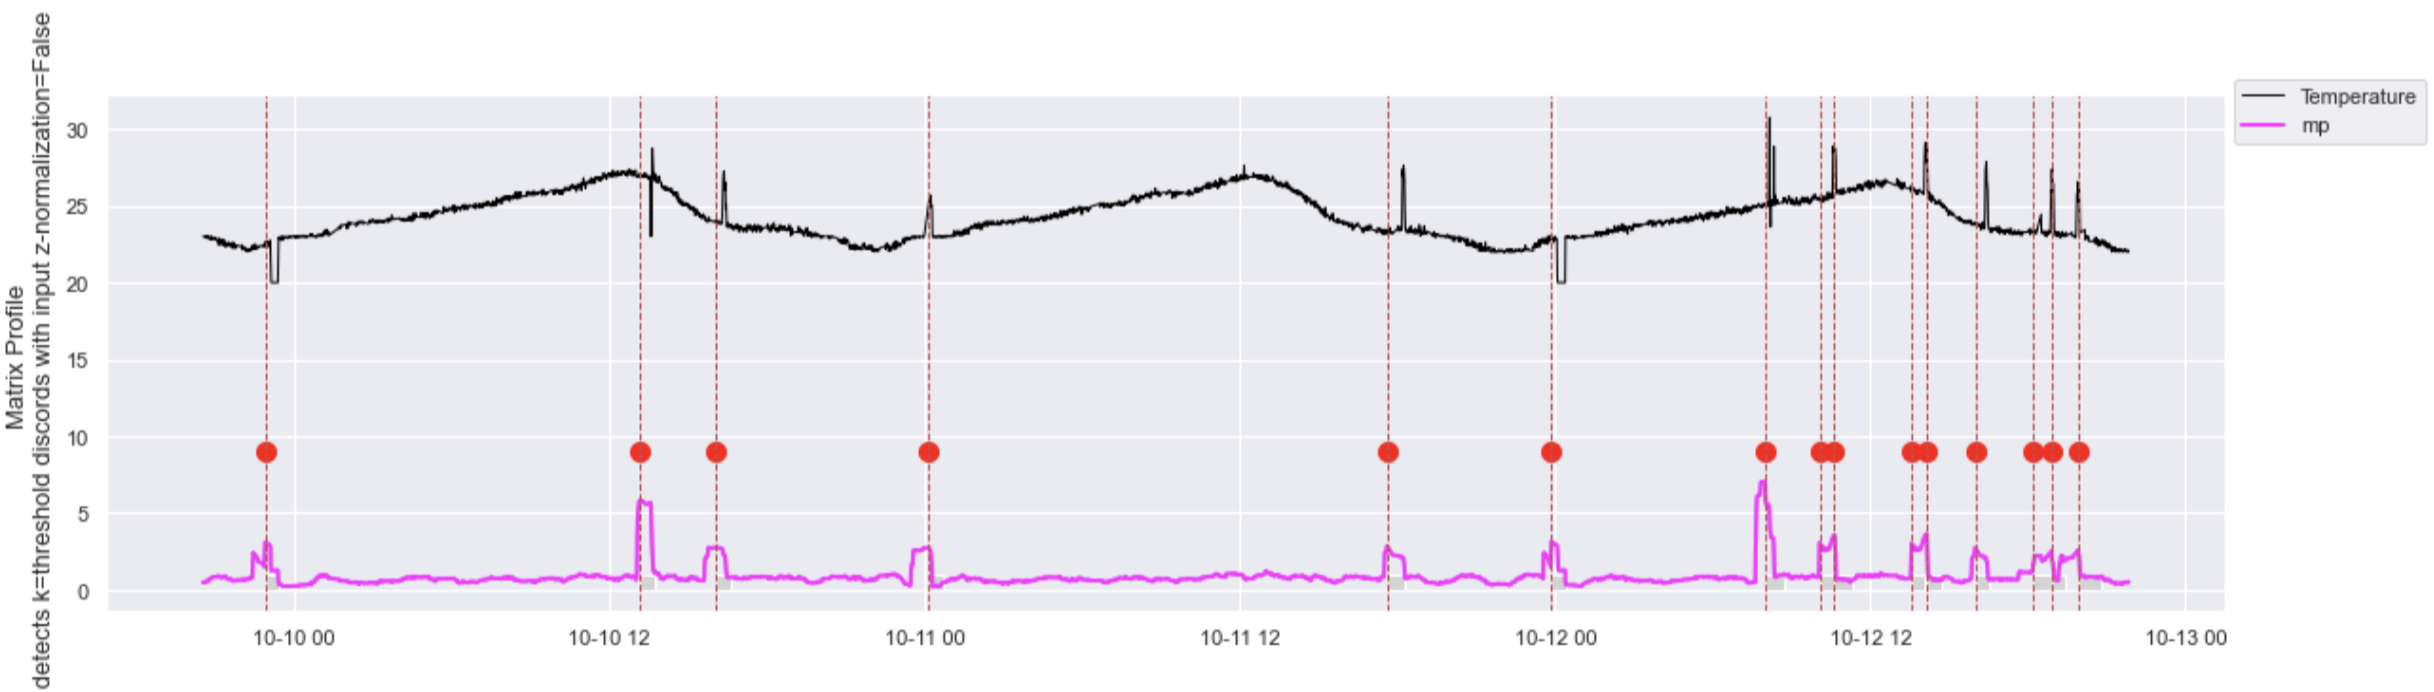


**The effect of window size** <br>
window_size determines the amount of data that forms one subsequece. To choose an appropriate window size the user should know the granurality  of data collection and determine the graularity of analysis. <br>
*An Example for determining window size: Sensor A is collecting data every 5 min and we want to analyze events for a 24 hour time period<br>
data_collection_frequency = 5min <br>
data_analysis_granularity = 1 hour <br>
window_size = 1hour/5min = 60min/5min = 12 <br>

minimum window size can be 3 (does this work on all data?)

**The effect of z_nomalization**

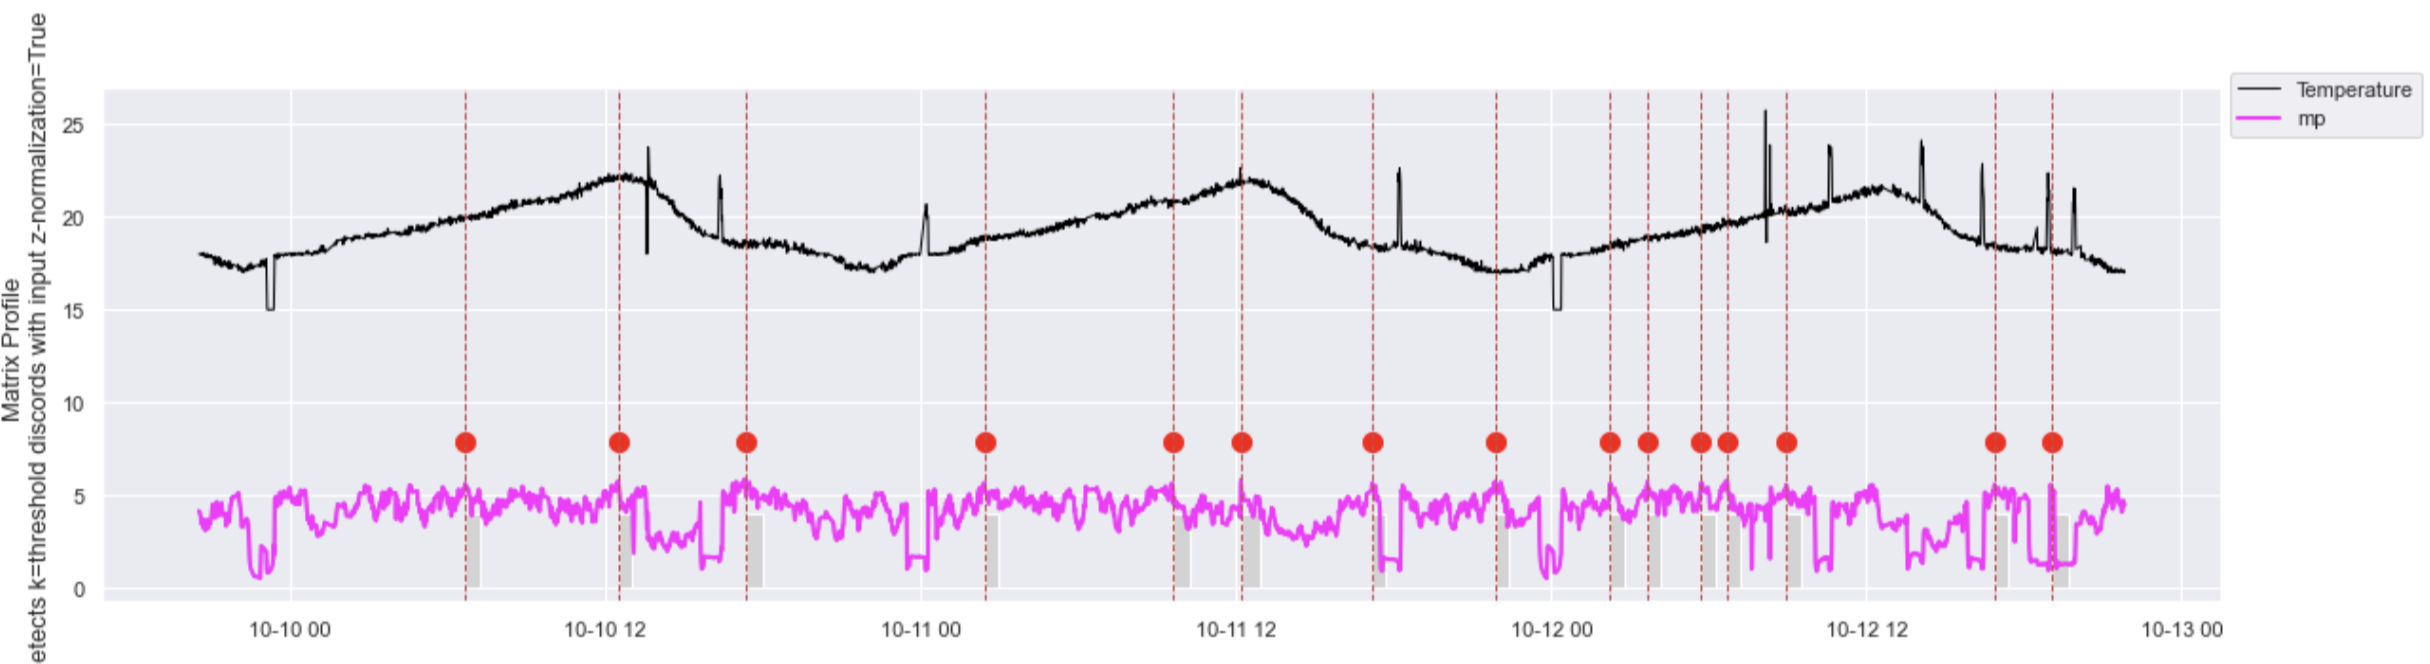

**Top k discords** <br>
Determines the number of anomaly we will detect for data in a single pipeline run. This can be a user input. We are detecting discords and not anomalies <br>

**Exclusion zone when detecting anomalies** <br>
Exclusion zone eliminates a window of entries around already founds discords when finding the next discord. This helps eliminate all the subsequence that include the anomaly caising the discord. The exclusion zone is set to the lenght of window_size <br>

In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

from src.comparingmodels import (utils, data, models)

import logging
from iotfunctions.enginelog import EngineLogging
EngineLogging.configure_console_logging(logging.INFO)

%load_ext autoreload
%autoreload 2
%matplotlib inline

/Applications/anaconda3/envs/ml_mmfunctions/lib/python3.7/site-packages/iotfunctions/bif.py:1884: UserWarning: IoTCalcSettings is deprecated. Use entity type constants instead of a metadata provider to set entity type properties
  warnings.warn(('IoTCalcSettings is deprecated. Use entity type constants'


#### STEPS TO ANALYZE ANOMALY MODELS FOR A GIVEN DATASET <br>
For a given data run the following cells in order <br>

**1. Data Processing** describes the data we want to analyze<br>
**2. Running existing anomaly models** runs the models and summarizes all the anomaly scores calculated from existing model<br>
**3. Visualizing the result** plots the anomaly scores calculated above<br>
**4. Matrix Profile - Anomaly Detection** calculates the matrix profile and plots the anomaly score derived from it<br>


## Select data by uncommenting the corresponding line

In [64]:
datapath='../data/AzureAnomalysample.csv'; columnname='Temperature'; entity='MyRoom'; datasel=columnname
#datapath='../data/Armstark04714B6046D5.csv'; columnname = 'vibrations'; entity='04714B6046D5'; datasel=columnname
#datapath='../data/Armstark04714B604101.csv'; columnname = 'vibrations'; entity='04714B604101'; datasel=columnname
#datapath='../data/Cakebread36_6months.csv'; columnname = 'floatvalue'; entity='CakebreadId_0036'; datasel=columnname
#datapath='../data/Cakebreak128.csv'; columnname = 'floatvalue'; entity='CakebreadId_0128'; datasel=columnname
#datapath = '../data/Anomaly_Sample_data.csv'; columnname='TEMPERATURE'; entity='A101'; datasel='pressure'

**1. Data Processing**

In [65]:
#column we want to analyze
md = data.MonitorData(data_sel = datasel)
df_i = md.get_data(datapath=datapath)

df_i.describe()

,Temperature
count,4000.000000
mean,24.264336
std,1.484244
min,20.000000
25%,23.062500
50%,24.000000
75%,25.437500
max,30.750000


Check duplicate in time

In [66]:
df_i.reset_index().duplicated(subset='timestamp').unique()

array([False])

In [70]:
df_i.head(10)

Temperature
entity timestamp                       
MyRoom 2017-10-09 20:32:00      23.0000
       2017-10-09 20:33:00      23.0000
       2017-10-09 20:34:00      23.0000
       2017-10-09 20:35:00      23.0000
       2017-10-09 20:36:00      23.0000
       2017-10-09 20:37:00      22.9375
       2017-10-09 20:38:00      23.0000
       2017-10-09 20:39:00      22.9375
       2017-10-09 20:40:00      23.0000
       2017-10-09 20:41:00      22.9375

**2. Running existing anomaly models**

In [67]:
#Define ExistingModels with the column we want to run the scoring on
em = models.ExistingModels(columnname=columnname)
df_anomaly = em.run_all(df_i)
df_anomaly.describe()

2020-10-12T14:43:07.286 INFO iotfunctions.dbtables.__init__ Init FileModelStore
2020-10-12T14:43:08.636 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-10-12T14:43:08.806 INFO iotfunctions.dbtables.__init__ Init FileModelStore
2020-10-12T14:43:09.910 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
Saliency   Entity: MyRoom, result shape: (665,) score shape: (665,) input shape: (4000,)
2020-10-12T14:43:10.617 INFO iotfunctions.dbtables.__init__ Init FileModelStore
2020-10-12T14:43:11.757 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-10-12T14:43:13.726 INFO iotfunctions.dbtables.__init__ Init FileModelStore
2020-10-12T14:43:14.726 WARNING i

,Temperature,SpectralAnomalyScore,SaliencyAnomalyScore,KmeansAnomalyScore,FFTAnomalyScore
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,24.264336,7.936961,91.769137,0.746214,87.139515
std,1.484244,29.140010,552.548935,1.044722,334.256136
min,20.000000,0.048718,0.892587,0.005014,0.000000
25%,23.062500,3.809004,7.262695,0.389343,8.609098
50%,24.000000,4.482759,16.533798,0.505011,13.440402
75%,25.437500,5.051216,34.005994,0.627507,19.741681
max,30.750000,815.618754,9997.383365,7.524000,4406.704597


**3. Visualizing the result**

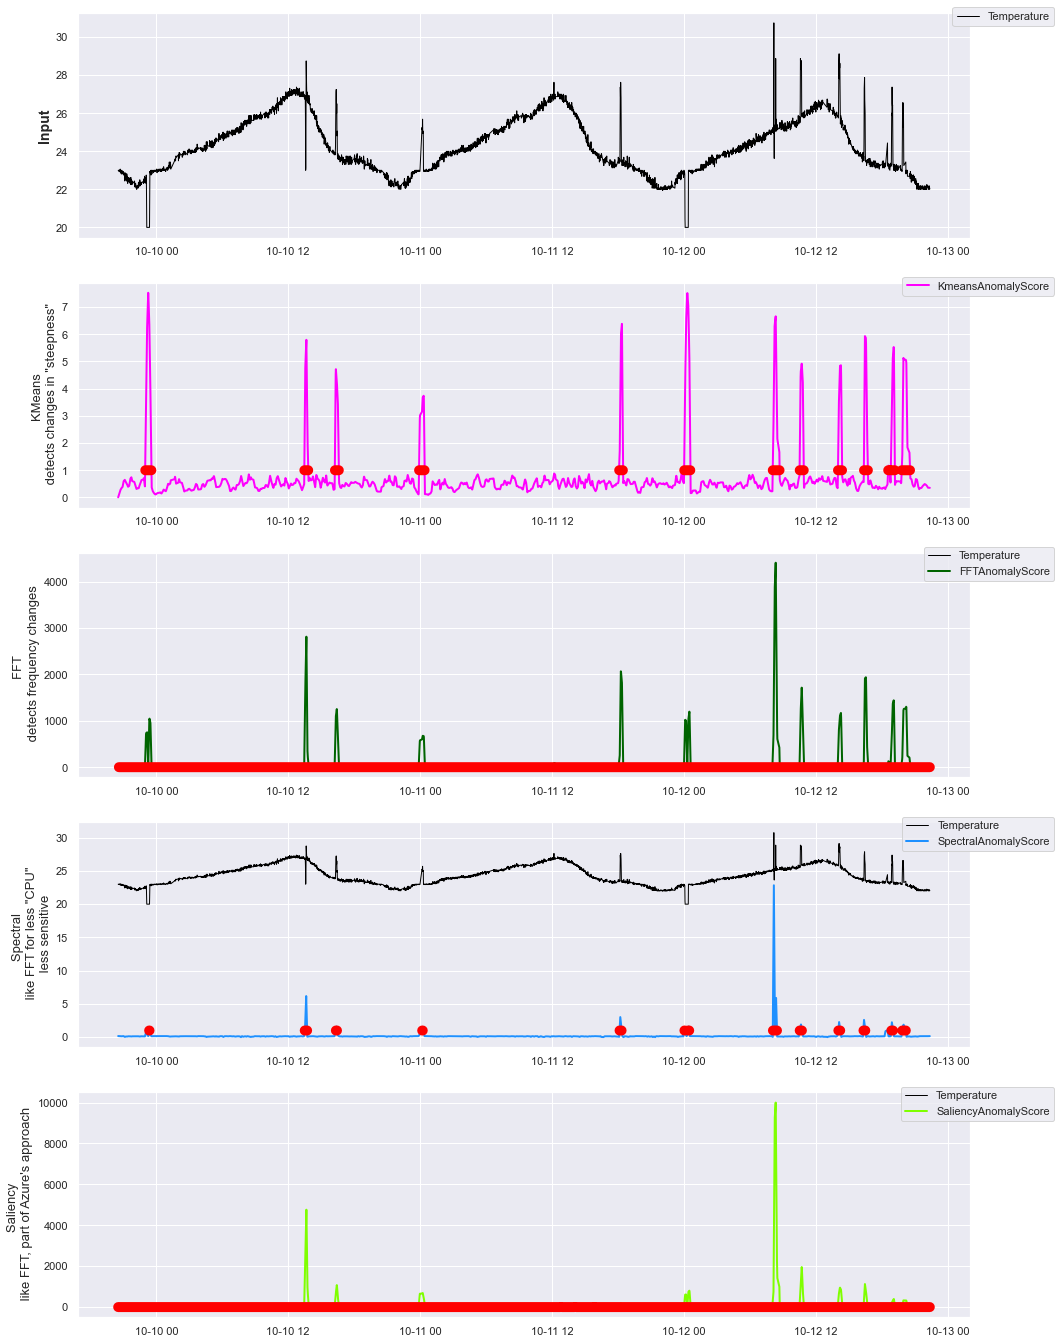

In [68]:
# Simplify dataframe to prepare input for plotting
df_plot = df_anomaly.loc[[entity]]
df_plot.reset_index(level=[0], inplace=True)
em.plot_all(df_plot)

***NEW MODEL*** <br>
**4. Matrix Profile - Anomaly Detection**

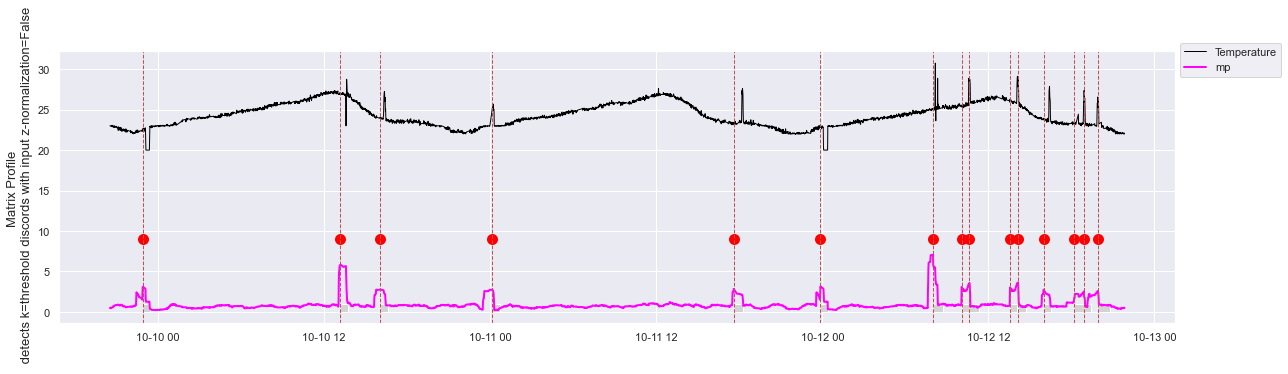

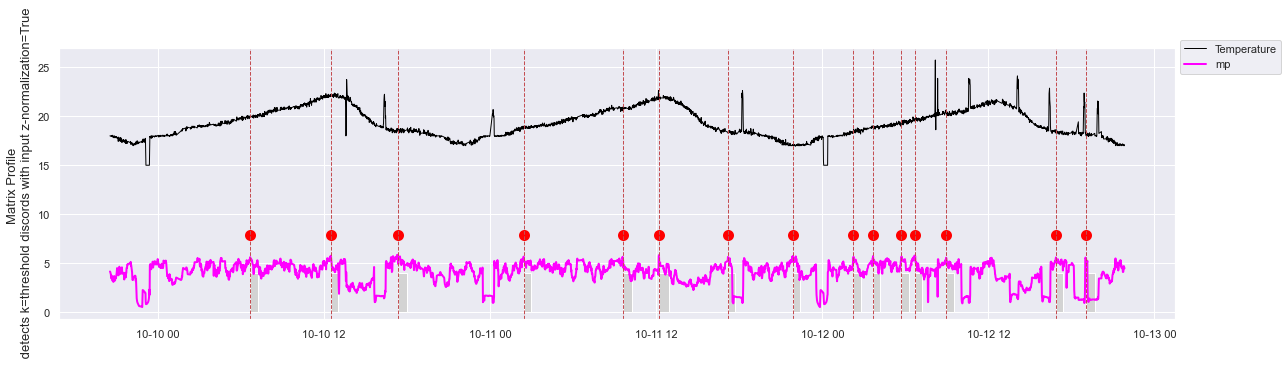

In [73]:
#Matrix Profile
window_size = 2**5
mp = models.MatrixProfile(df=df_i, columnname=columnname, windowsize=window_size,z_normalized=False)
mp.run_model()
df_ret = mp.plot_mp(threshold=15, columnsub=0, printdata=False, motif=False)

#Matrix Profile: z-normalized input
window_size = 2**5
mp_norm = models.MatrixProfile(df=df_i, columnname=columnname, windowsize=window_size,z_normalized=True)
mp_norm.run_model()
df_ret_norm = mp_norm.plot_mp(threshold=15, columnsub=5, printdata=False, motif=False)

In [51]:
df_ret.describe()

,floatvalue,mp,anomaly
count,7899.000000,7899.000000,5.000000
mean,35.423712,1.374408,18.145277
std,8.782015,0.974984,0.000000
min,0.000000,0.173202,18.145277
25%,26.500000,0.812404,18.145277
50%,41.299999,1.212435,18.145277
75%,43.700001,1.646207,18.145277
max,55.700001,16.145277,18.145277


In [52]:
df_ret_norm.describe()

,floatvalue,mp,anomaly
count,7899.000000,7899.000000,5.000000
mean,35.423712,0.728794,3.409351
std,8.782015,0.205855,0.000000
min,0.000000,0.079666,3.409351
25%,26.500000,0.592412,3.409351
50%,41.299999,0.736601,3.409351
75%,43.700001,0.874220,3.409351
max,55.700001,1.409351,3.409351
